In [1]:
import torch as pt
import torch.nn as nn
from torch.utils.data import random_split
from src.dataset import MolDataset
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score, cohen_kappa_score
import sys

/home/dima/miniconda3/envs/ctpesto/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format =   'svg'

In [3]:
pt.manual_seed(110)
device = "cuda" if pt.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Dataset and Net

In [4]:
N = 18000
dataset = MolDataset("../data/preprocessed/X.pk", 
                     y_datafile="../data/preprocessed/Y.pk", normal = False)
train_dataset, test_dataset = random_split(dataset, [len(dataset) - N, N])

In [12]:
dataset[33][0].shape

(1, 1024)

In [10]:
print(len(dataset)/np.sum(dataset[:][1], axis=0))

[34.64527193 24.94215168  1.07406395]


In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

    

In [29]:

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)


#  Train

## Example

In [30]:
ids = [8,2100,11111, 3674,9867]

X1 = train_dataset[ids][0]
X = pt.tensor(X1, device=device)
treu_y = dataset[ids][1]

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(2)
print(f"Predicted class: {y_pred}")
print(f"True classes: {treu_y.argmax(1)}")

Predicted class: tensor([[0, 0, 0, 2, 2]], device='cuda:0')
True classes: [0 1 2 1 2]


## Parameters of training

In [34]:
class_weights = pt.Tensor([3.5, 2.5,0.1])
class_weights.to(device)

tensor([3.5000, 2.5000, 0.1000], device='cuda:0')

In [35]:
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = pt.optim.Adam(model.parameters())

In [36]:
loss_fn.to(device)

BCEWithLogitsLoss()

In [37]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        x = X.to(device)
        y = Y[:,None,:].to(device)
        pred = model(x)
        # print(pred,y)
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            
            #convert to classes
            # m = pred.squeeze(1)
            # pred_probab = nn.Softmax(dim=1)(m)    
            # pred_cats = np.array(pred_probab.argmax(1).cpu())
            # true_cat = Y.argmax(1).cpu()
            # score = f1_score(pred_cats, true_cat, average=None)
            
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # print(f"score {score}")



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    score = 0
    with pt.no_grad():
        for X, Y in dataloader:
            x = X.to(device)
            y = Y[:,None,:].to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y.float()).item()
            
                        #convert to classes
            m = pred.squeeze(1)
            pred_probab = nn.Softmax(dim=1)(m)    
            pred_cats = np.array(pred_probab.argmax(1).cpu())
            true_cat = Y.argmax(1).cpu()
            ts = f1_score(pred_cats, true_cat, average=None)
            ts2 = cohen_kappa_score(pred_cats, true_cat)
            # print(ts.shape)
            score += ts2


    test_loss /= num_batches
    #     correct /= size
    #     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # print(f"Avg loss: {test_loss:>8f} score: {score/36.}\n")
    return(score/36.)


In [38]:
epochs = 350
# train model
train_dataloader = DataLoader(train_dataset, batch_size=512,
                              shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=512,
                             shuffle=True, pin_memory=True)
scores = []
for t in range(epochs):
    sys.stdout.write(f"{t} ") 
    # print(f"Epoch {t + 1}\n-------------------------------")
    # logger.store_progress(0, is_train=True, epoch=t+1)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    s = test_loop(test_dataloader, model, loss_fn)
    scores.append(s)
print("Done!")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 28

(-1e-05, 0.1)

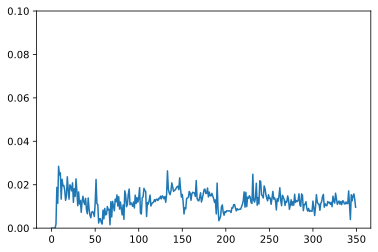

In [39]:
plt.plot(scores)
plt.ylim([-0.00001,0.1])

In [ ]:
pt.save(model.state_dict(), "model.pt")

In [ ]:
with pt.no_grad():
    for X, Y in train_dataloader:
        x = X.to(device)
        y = Y[:,None,:].to(device)

In [ ]:
logits = model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

In [ ]:
x.shape

In [ ]:
logits[0:10]

In [ ]:
y[0:8,:,:]